In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from datetime import datetime
import json

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family ='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


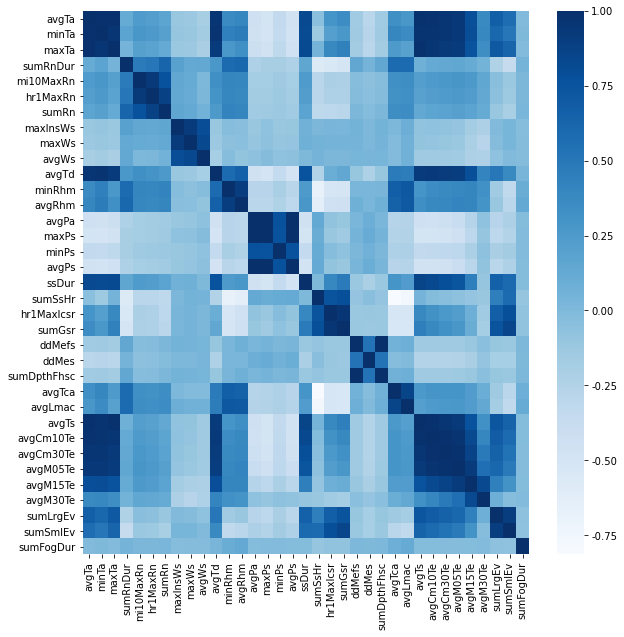

In [3]:
# 추출한 날씨데이터 가져오기
wth_df = pd.read_csv('wth_data_20211025.csv',index_col=0)
# Nan값 데이터 0으로 채우기
wth_df.fillna(0, inplace=True)
wth_df['tm'] = pd.to_datetime(wth_df['tm'])

# 날씨데이터의 index 날짜로 설명
wth_df = wth_df.set_index(wth_df['tm'])
wth_df.drop('tm', axis=1, inplace=True)

# 각 칼럼별 연관성 파악
wth_df.corr(method='pearson')
plt.figure(figsize =(10,10))
sns.heatmap(wth_df.corr(method='pearson'),cmap='Blues', fmt ='.2f')
plt.savefig('img/all.png')

In [4]:
# 날씨 데이터 스케일러
from sklearn.preprocessing import StandardScaler
x = wth_df.loc[:, :]
x_tr=StandardScaler().fit_transform(x)
wth_df2= pd.DataFrame(x_tr, index=wth_df.index, columns=wth_df.columns)

In [5]:
wth_df2.head()

avgTa     minTa     maxTa  sumRnDur  mi10MaxRn  hr1MaxRn  \
tm                                                                        
2000-01-01 -0.718637 -0.694393 -0.718555 -0.503927   -0.27865 -0.256369   
2000-01-02 -0.842505 -0.949194 -0.998957  1.028813   -0.27865 -0.256369   
2000-01-03 -1.452313 -1.298367 -1.634533 -0.503927   -0.27865 -0.256369   
2000-01-04 -1.214107 -1.270056 -1.241971 -0.503927   -0.27865 -0.256369   
2000-01-05 -0.975900 -0.854823 -1.213931  2.615412   -0.27865 -0.256369   

               sumRn  maxInsWs     maxWs     avgWs  ...   avgLmac     avgTs  \
tm                                                  ...                       
2000-01-01 -0.254797 -0.409162 -0.655918 -0.050766  ... -0.378277 -0.992746   
2000-01-02  0.144045  1.235063  1.777072  1.490172  ...  0.354898 -0.894739   
2000-01-03 -0.254797 -0.147581  0.628160  0.423369  ... -1.070721 -1.447142   
2000-01-04 -0.254797 -1.492856 -1.331748 -0.761968  ...  0.314166 -1.393683   
2000-01-05  0.968320  0.226107  0.155079  1.016037  ...  1.413930 -1.224399   

            avgCm10Te  avgCm30Te  avgM05Te  avgM15Te  avgM30Te  sumLrgEv  \
tm                                                                         
2000-01-01  -1.350764  -1.354772 -1.239560 -0.845284 -0.284488 -1.059499   
2000-01-02  -1.331375  -1.344196 -1.228286 -0.892016 -0.310740 -1.059499   
2000-01-03  -1.341070  -1.354772 -1.262110 -0.923170 -0.310740 -1.059499   
2000-01-04  -1.350764  -1.354772 -1.262110 -0.923170 -0.310740 -1.059499   
2000-01-05  -1.350764  -1.354772 -1.262110 -0.923170 -0.310740 -1.059499   

            sumSmlEv  sumFogDur  
tm                               
2000-01-01 -1.145904   -0.10956  
2000-01-02 -1.193913   -0.10956  
2000-01-03 -1.193913   -0.10956  
2000-01-04 -1.241921   -0.10956  
2000-01-05 -0.761840   -0.10956  

[5 rows x 35 columns]

In [6]:
wth_df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7969 entries, 2000-01-01 to 2021-10-25
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   avgTa        7969 non-null   float64
 1   minTa        7969 non-null   float64
 2   maxTa        7969 non-null   float64
 3   sumRnDur     7969 non-null   float64
 4   mi10MaxRn    7969 non-null   float64
 5   hr1MaxRn     7969 non-null   float64
 6   sumRn        7969 non-null   float64
 7   maxInsWs     7969 non-null   float64
 8   maxWs        7969 non-null   float64
 9   avgWs        7969 non-null   float64
 10  avgTd        7969 non-null   float64
 11  minRhm       7969 non-null   float64
 12  avgRhm       7969 non-null   float64
 13  avgPa        7969 non-null   float64
 14  maxPs        7969 non-null   float64
 15  minPs        7969 non-null   float64
 16  avgPs        7969 non-null   float64
 17  ssDur        7969 non-null   float64
 18  sumSsHr      7969 non-null   f

In [7]:
theme_list = ['자동차 대표주', '항공기부품', '생명보험', '조선','LNG(액화천연가스)', '원자력발전','정유', 'LPG(액화석유가스)',
              '방위산업/전쟁 및 테러','제습기','핵융합에너지','SNS(소셜네트워크서비스)','클라우드 컴퓨팅', '건설 대표주', 
              '겨울','공기청정기', '의료기기','풍력에너지', '태양광에너지', '전력설비', '재난/안전(지진 등)', '도시가스',
              '콜드체인(저온 유통)', '타이어','여행','희귀금속(희토류 등)','여름','페인트','시멘트/레미콘','황사/미세먼지', 
              '태풍 및 장마', '블록체인','인터넷 대표주',  '핀테크(FinTech)', '4차산업 수혜주' ,'T 대표주']

In [9]:
import glob

<ipython-input-21-7ec97a28aaaa>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.now()
<ipython-input-21-7ec97a28aaaa>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize =(4,4))


방위산업_전쟁 및 테러
재난_안전(지진 등)


OSError: encoder error -8 when writing image file

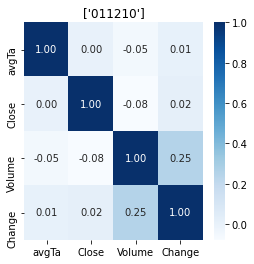

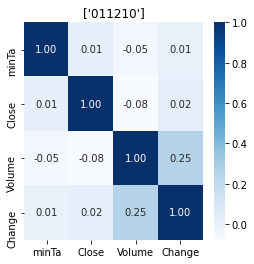

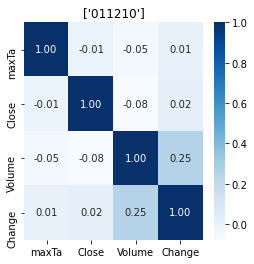

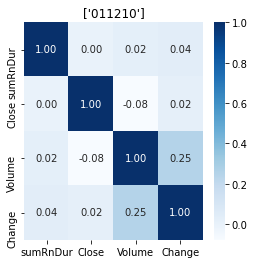

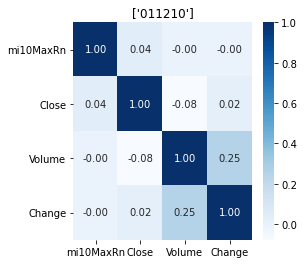

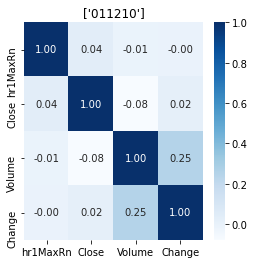

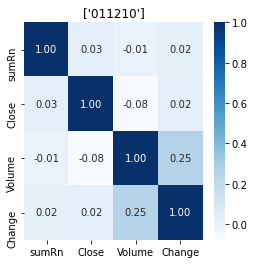

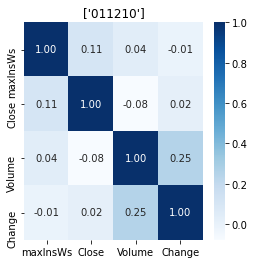

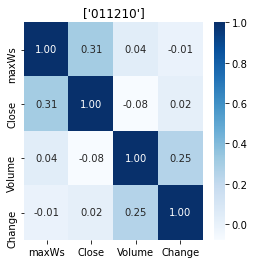

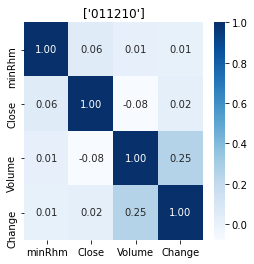

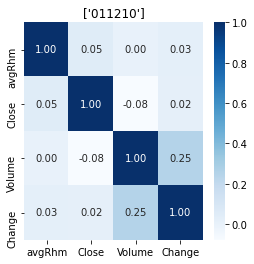

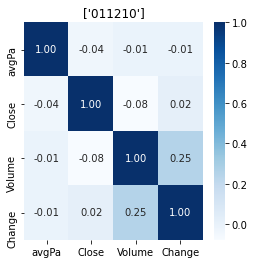

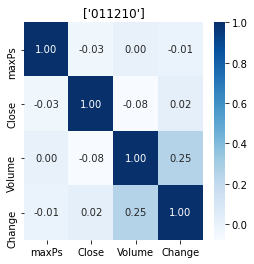

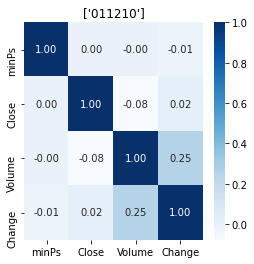

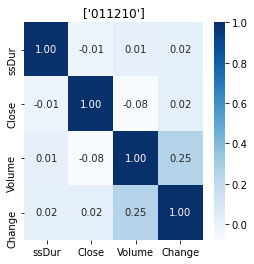

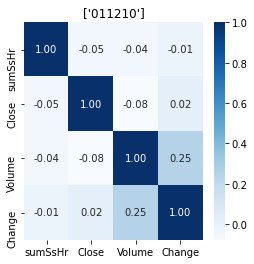

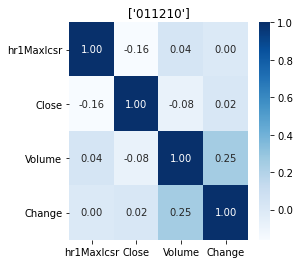

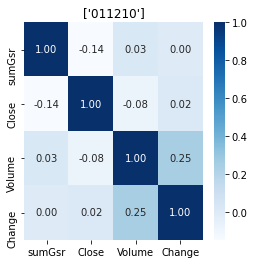

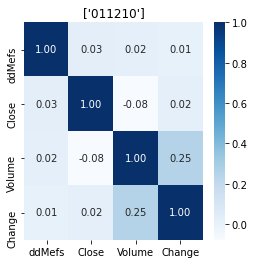

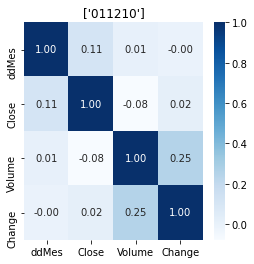

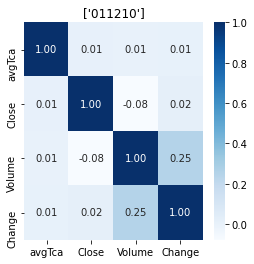

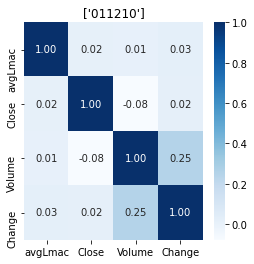

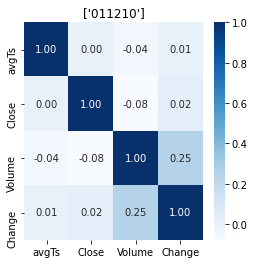

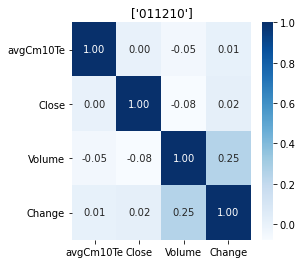

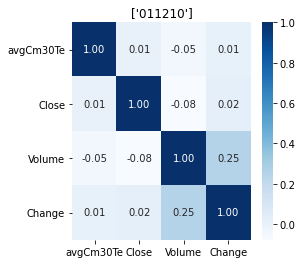

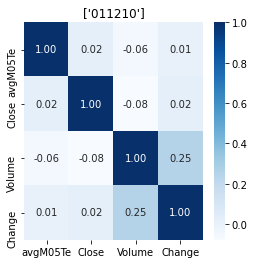

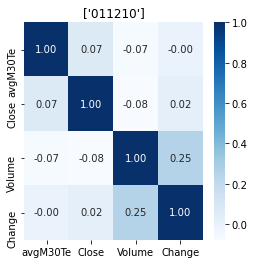

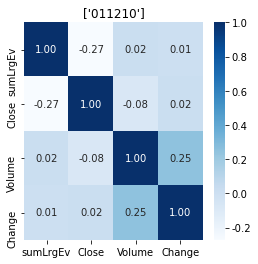

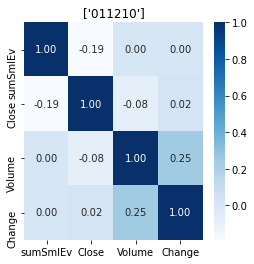

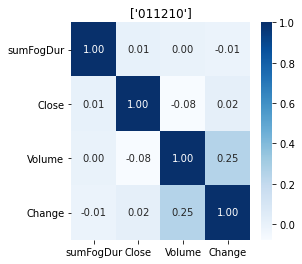

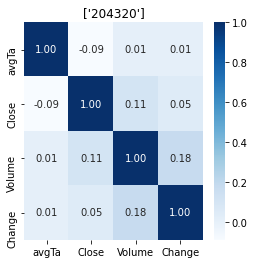

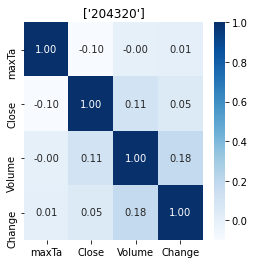

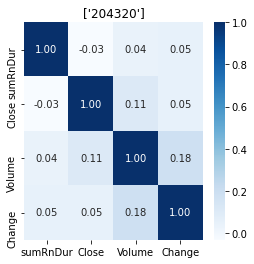

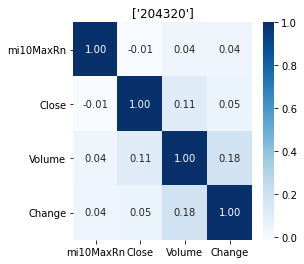

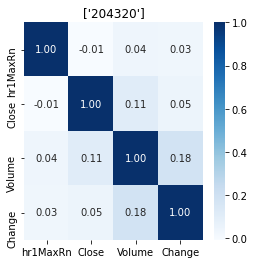

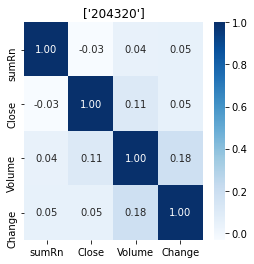

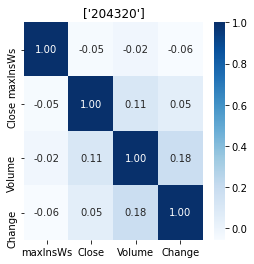

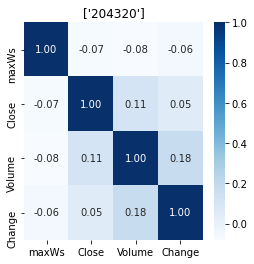

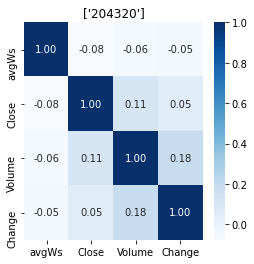

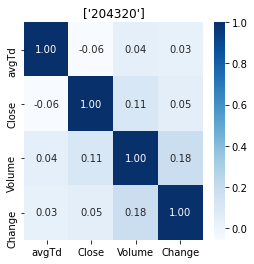

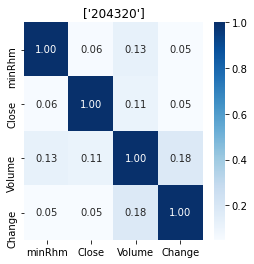

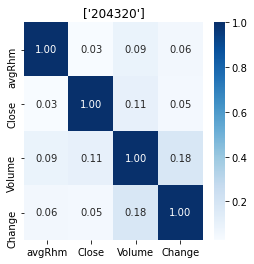

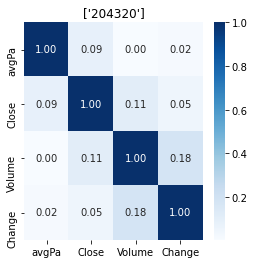

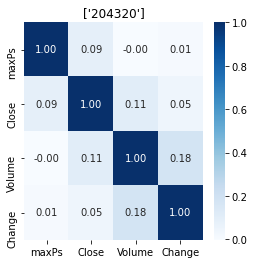

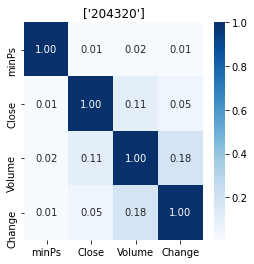

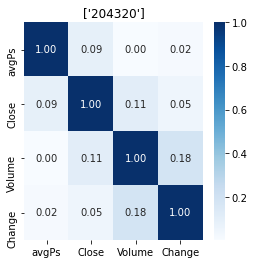

In [ ]:
today = pd.datetime.now()
today_str = str(today)[:10].replace('-','')

t_name=[]
for i in range(len(theme_list)):
    t_name=theme_list[i]
    
    if '/' in t_name:
        t_name=str(t_name).replace('/','_')
        print(t_name)
        
    theme_nm='{}'.format(t_name)
#     path = '테마별 주식데이터/{}_list_{}.csv'.format(theme_nm, today_str)
    try:
        path = '테마별 주식데이터/{}_list_20211027.csv'.format(theme_nm)
    except:
        pass
    df_theme_code_result = pd.read_csv(path,index_col=0)
    df_theme_code_result = df_theme_code_result.set_index(df_theme_code_result['Date'])
    df_theme_code_result.drop('Date',axis=1,inplace=True)
    df_theme_code_result.cd = df_theme_code_result.cd.apply(lambda x : str(x).zfill(6))

    df_list=[]

    for i in range(len(df_theme_code_result.cd.unique())) : 
        code = df_theme_code_result.cd.unique()[i]
        df = df_theme_code_result[df_theme_code_result['cd']==code]
        df_list.append(df)
        
        
    for j in range(len(df_list)) : 
        
        for s in range(35):
            df_list[j].index = df_list[j].index.astype('datetime64[ns]')
            c=wth_df2.columns[s]
            d2= pd.DataFrame(wth_df2[c])
        #     print(c, d2)
            d2.index = d2.index.astype('datetime64[ns]')
        #     print(j)

            join_df = d2.join(df_list[j], how='inner')
        #     print(df_list[j].cd.unique())
            plt.figure(figsize =(4,4))
            plt.title(df_list[j].cd.unique())
            sns.heatmap(join_df.corr(method='pearson'),annot=True, cmap='Blues', fmt ='.2f')
#             plt.savefig('img/{}_{}_{}.png'.format(theme_nm,df_list[j].cd.unique(),c))

<ipython-input-52-ae4cdab7612d>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.now()
<ipython-input-52-ae4cdab7612d>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize =(4,4))


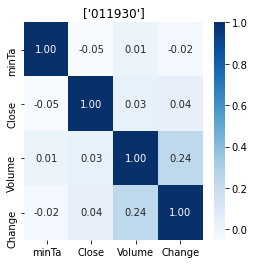

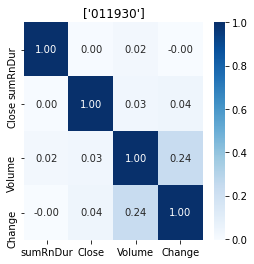

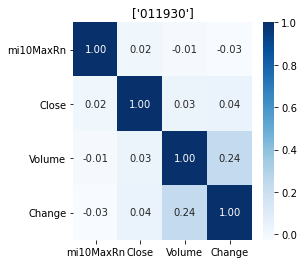

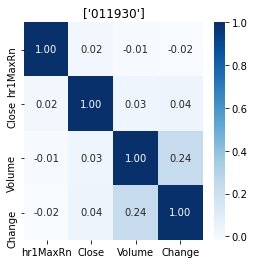

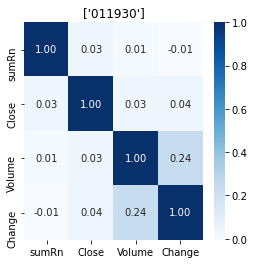

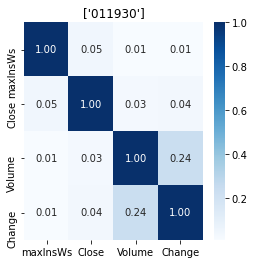

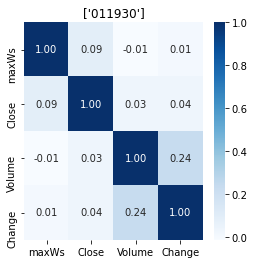

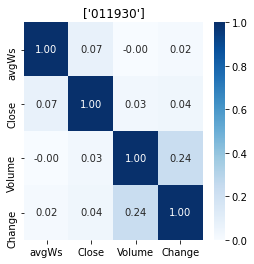

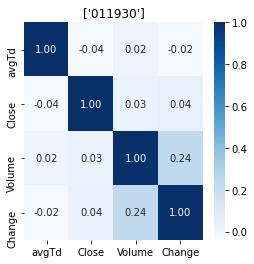

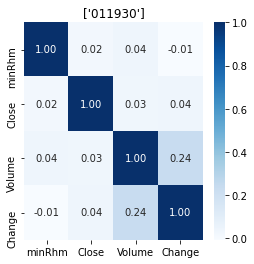

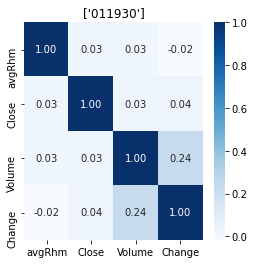

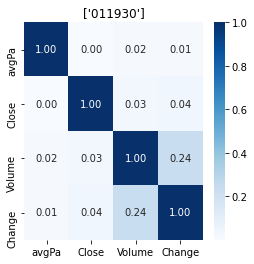

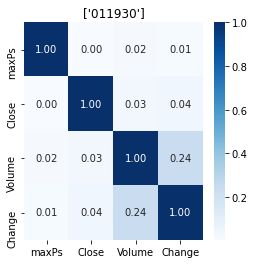

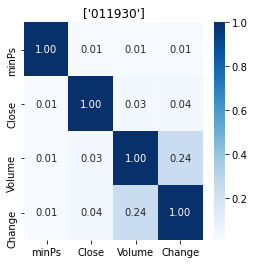

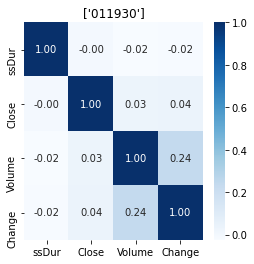

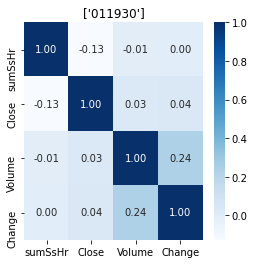

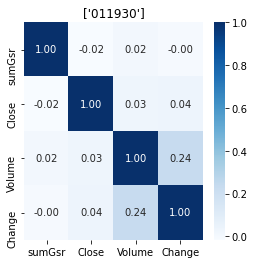

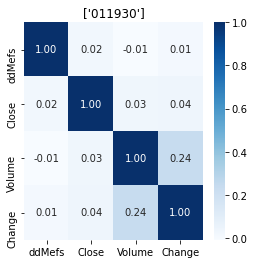

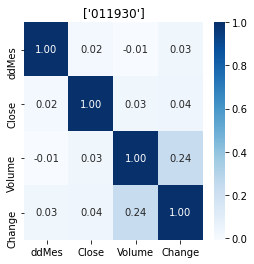

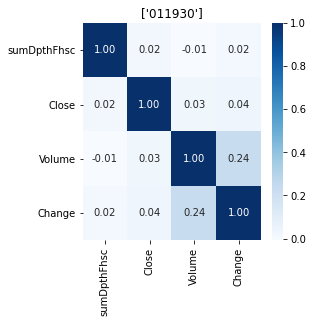

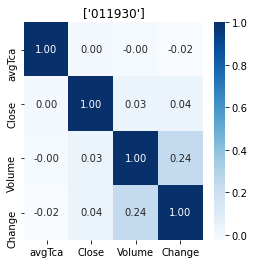

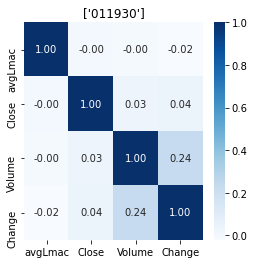

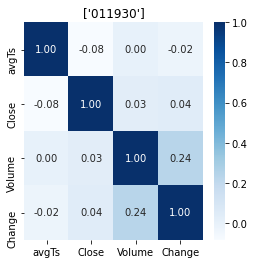

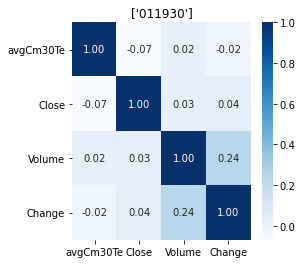

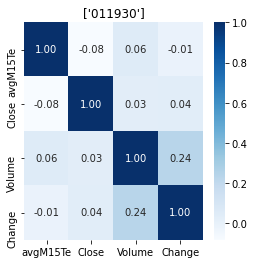

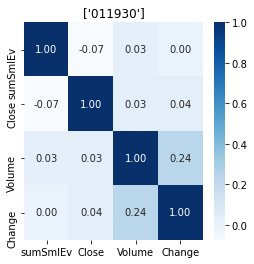

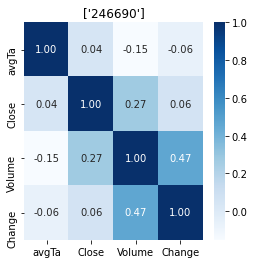

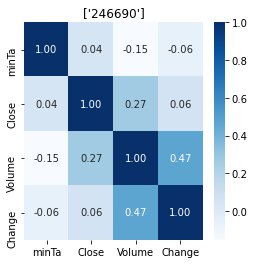

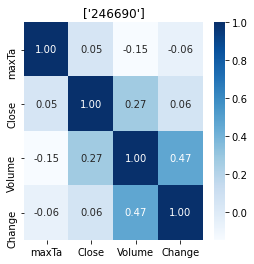

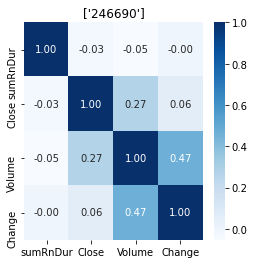

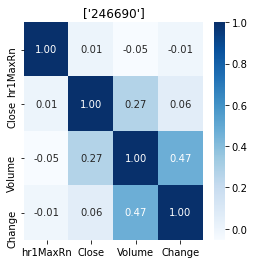

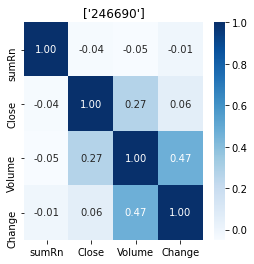

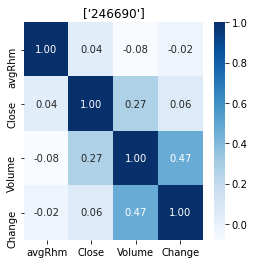

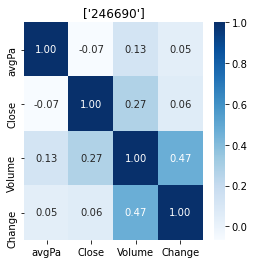

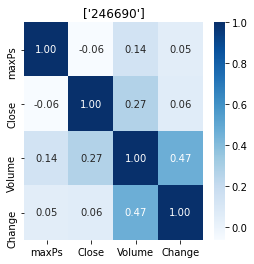

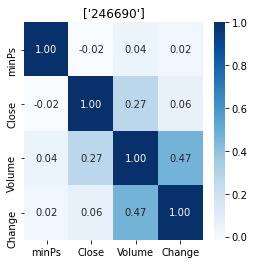

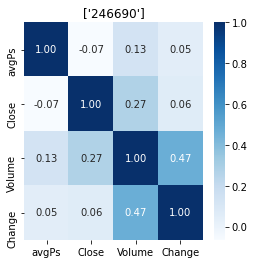

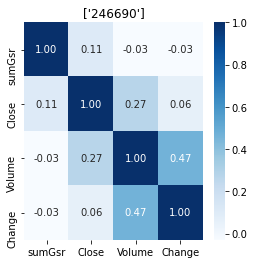

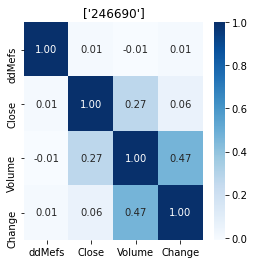

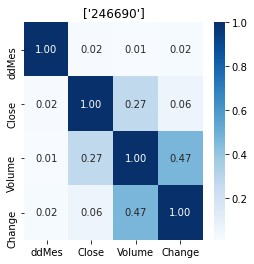

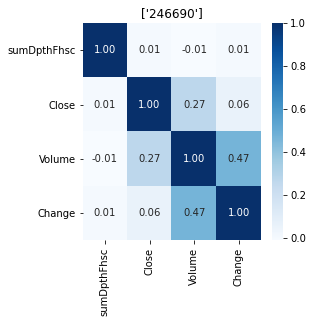

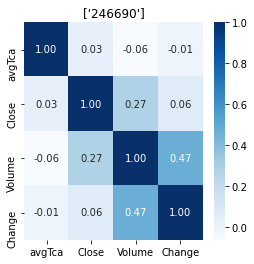

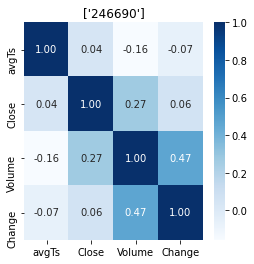

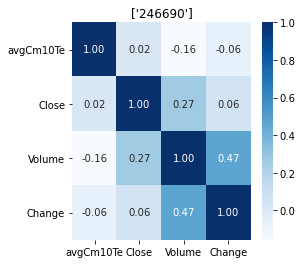

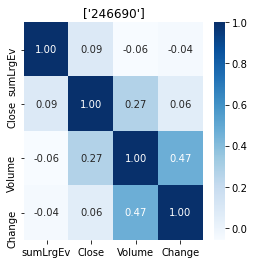

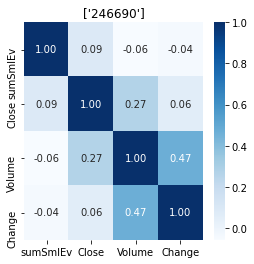

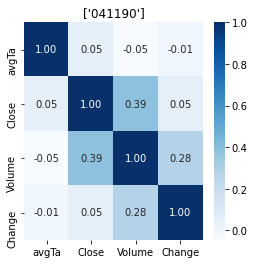

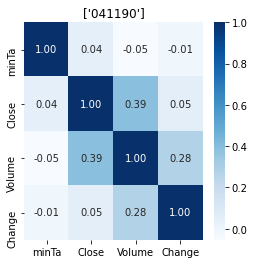

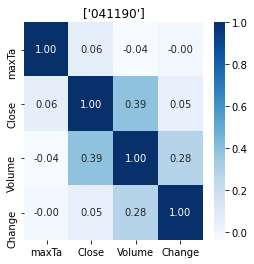

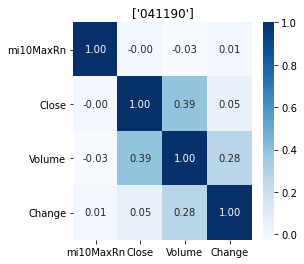

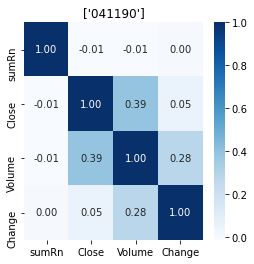

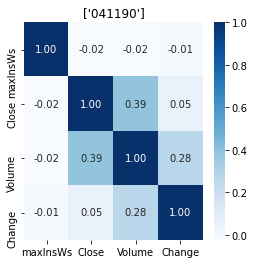

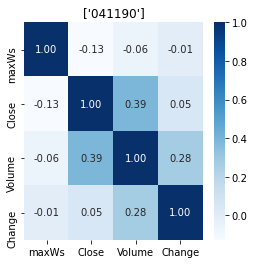

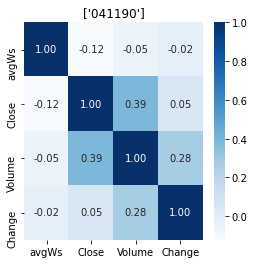

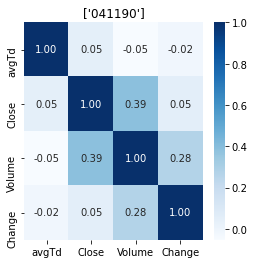

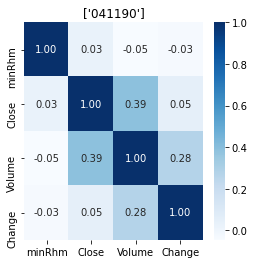

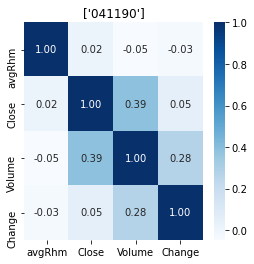

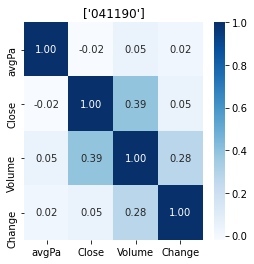

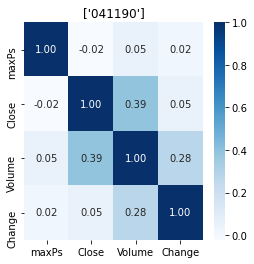

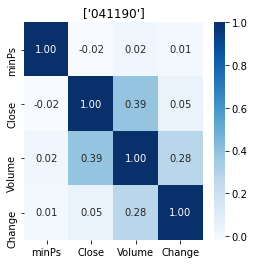

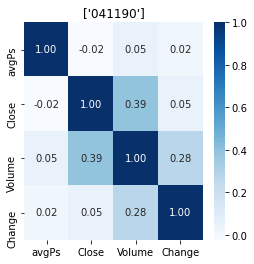

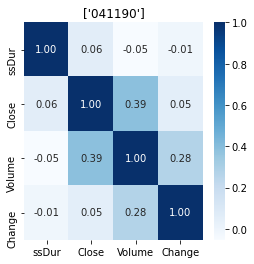

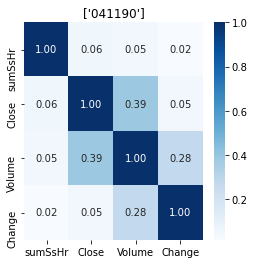

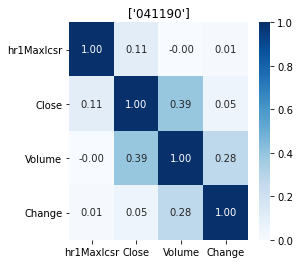

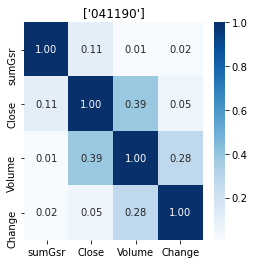

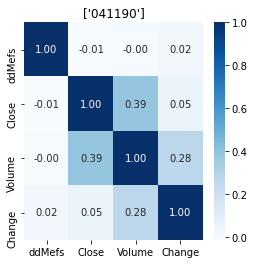

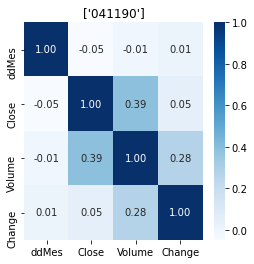

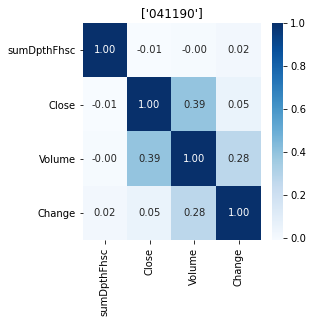

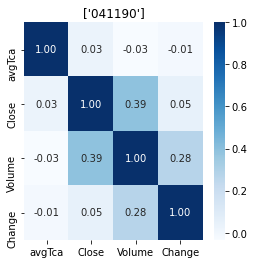

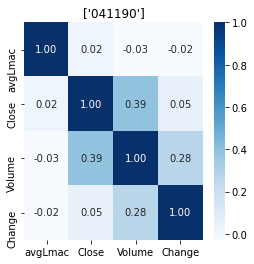

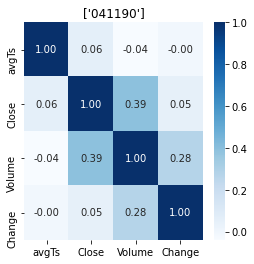

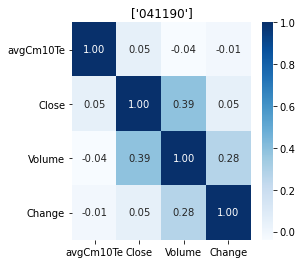

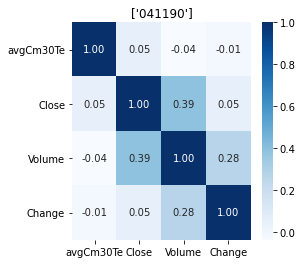

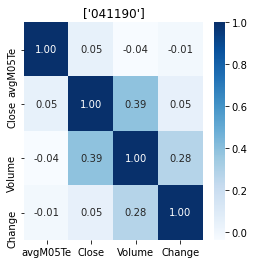

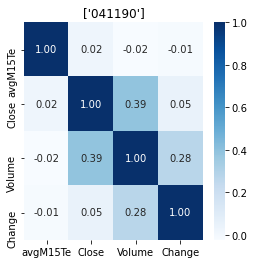

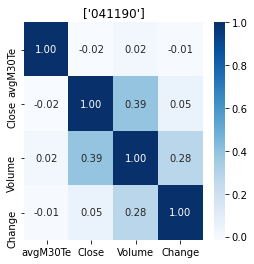

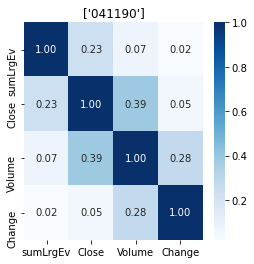

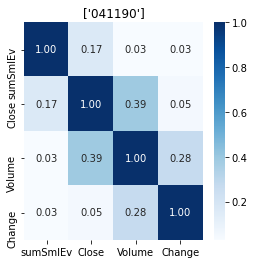

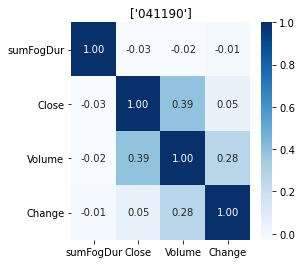

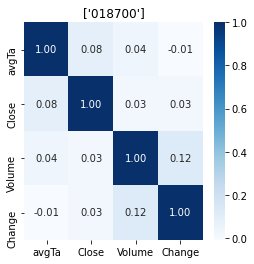

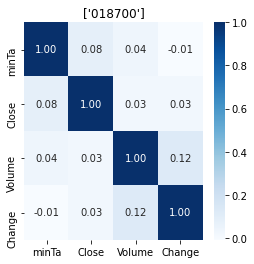

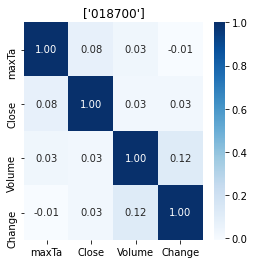

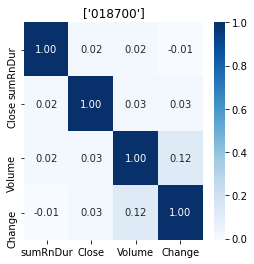

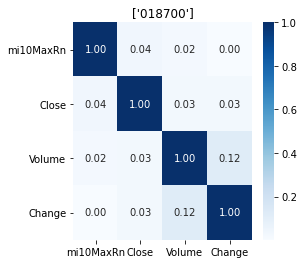

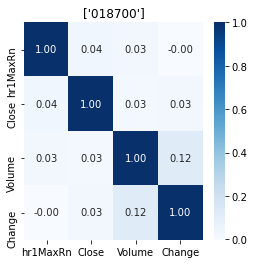

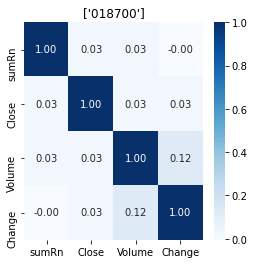

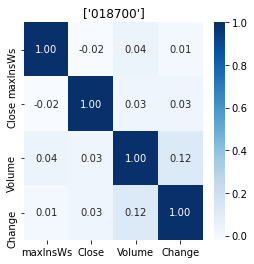

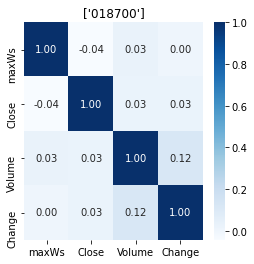

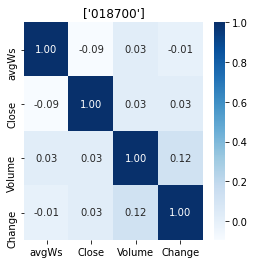

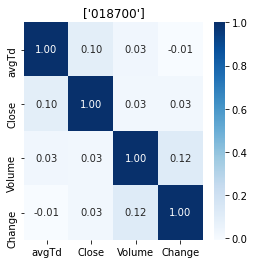

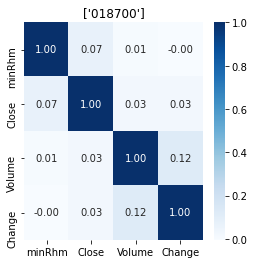

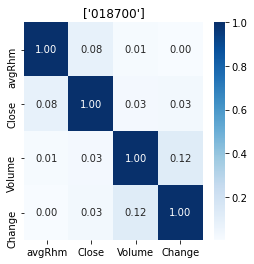

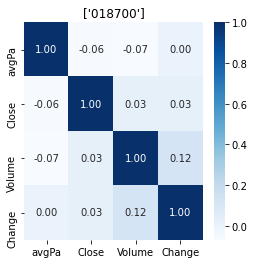

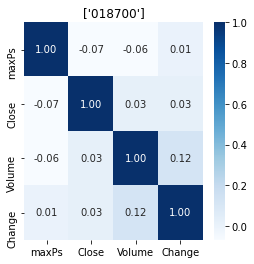

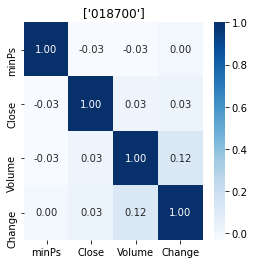

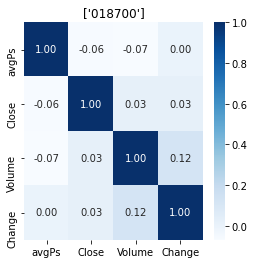

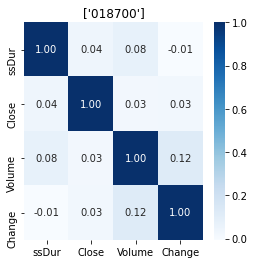

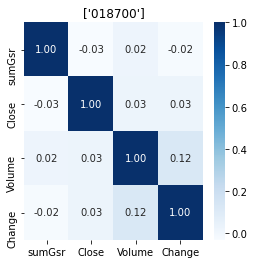

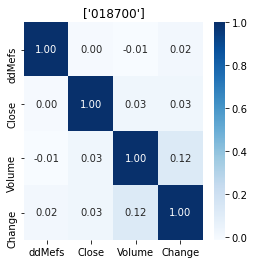

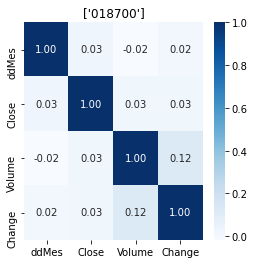

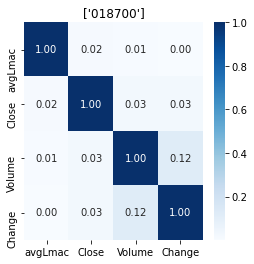

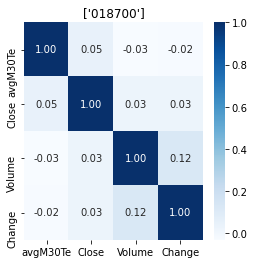

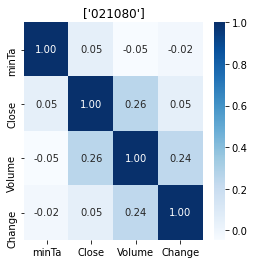

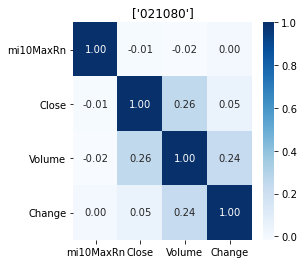

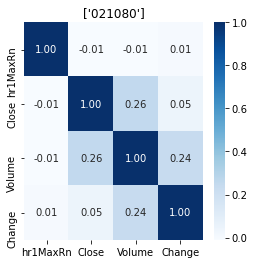

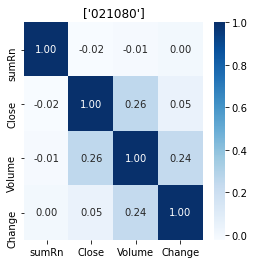

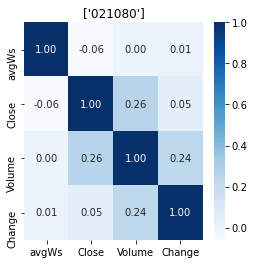

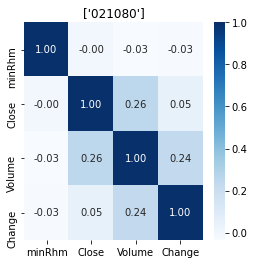

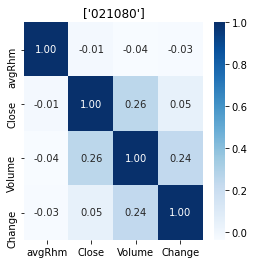

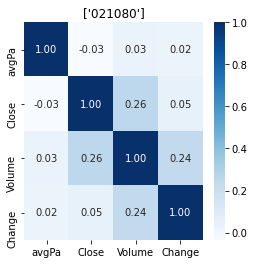

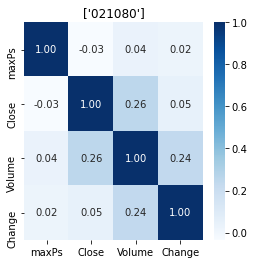

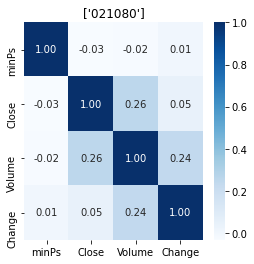

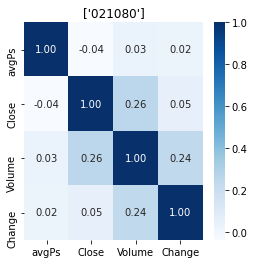

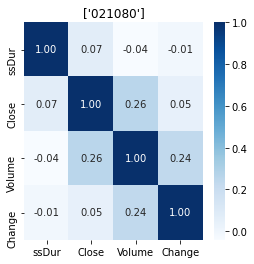

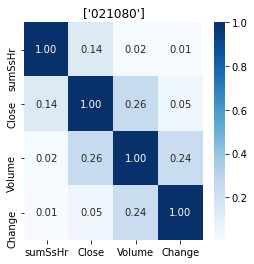

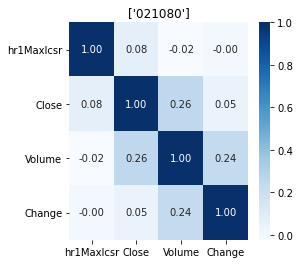

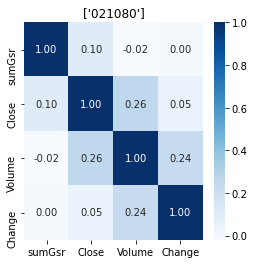

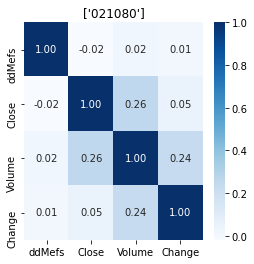

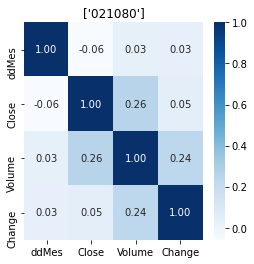

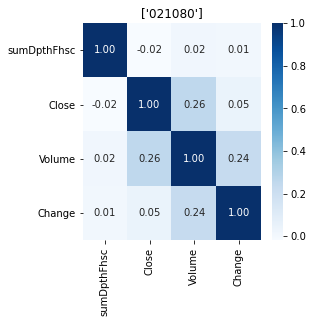

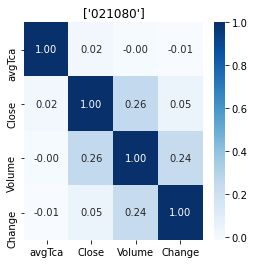

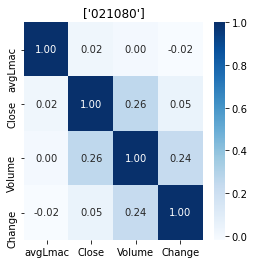

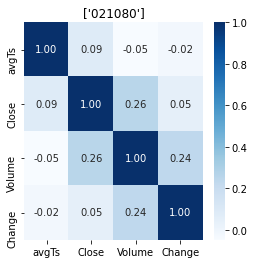

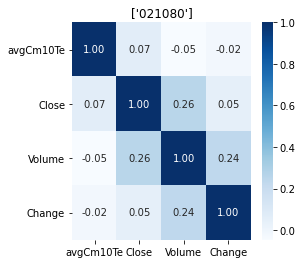

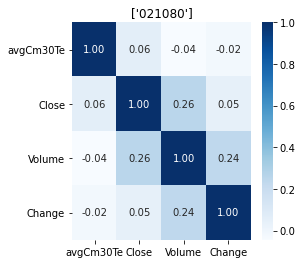

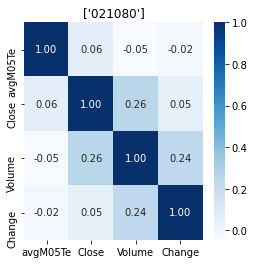

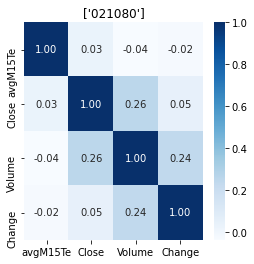

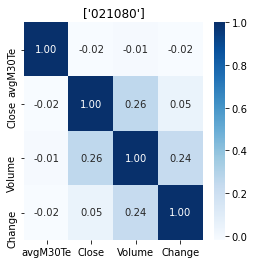

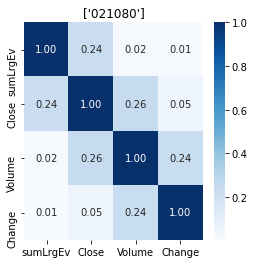

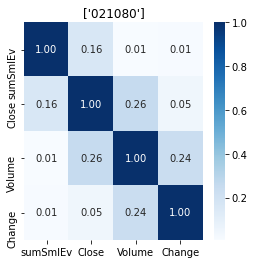

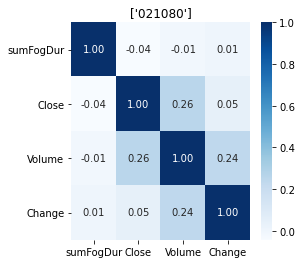

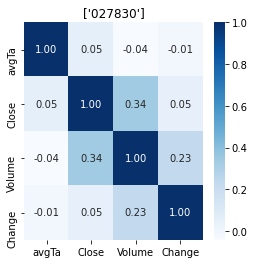

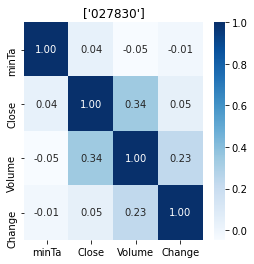

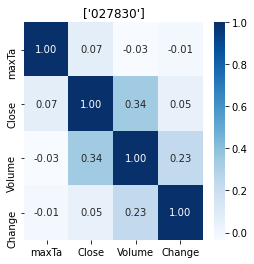

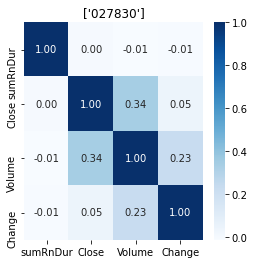

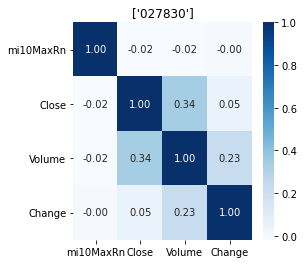

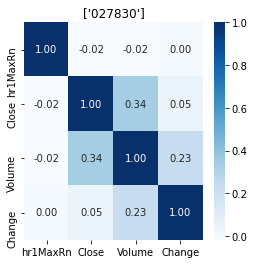

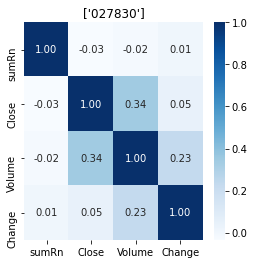

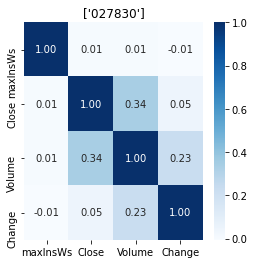

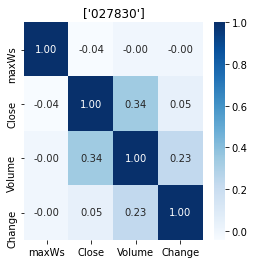

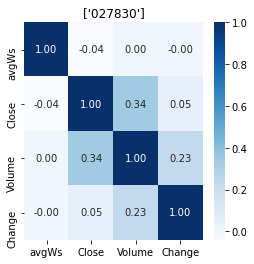

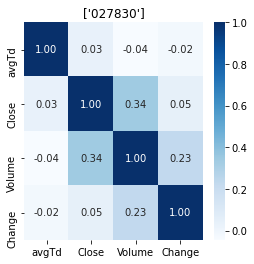

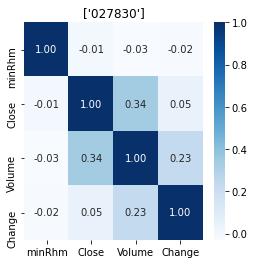

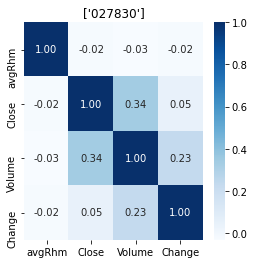

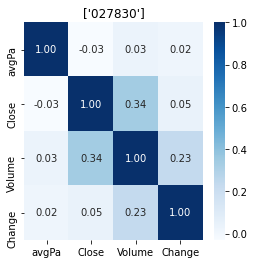

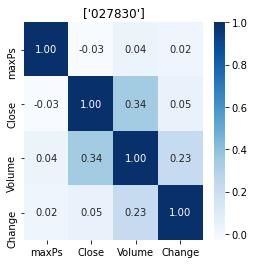

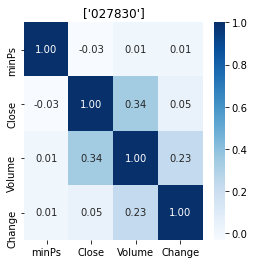

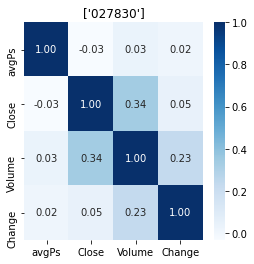

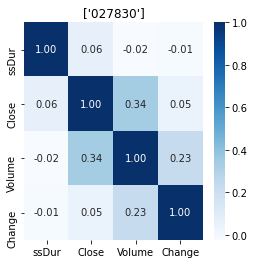

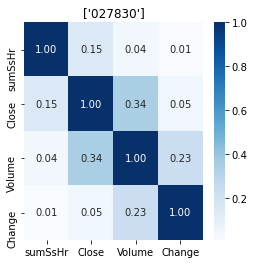

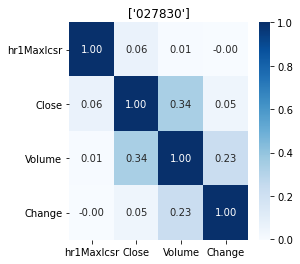

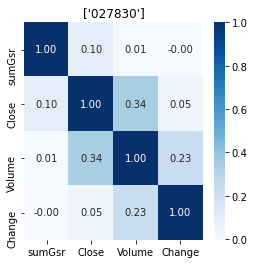

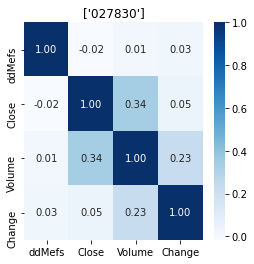

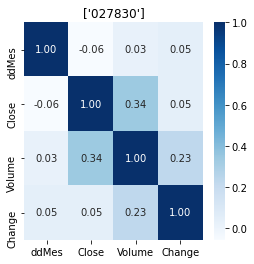

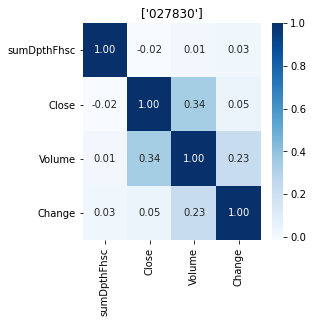

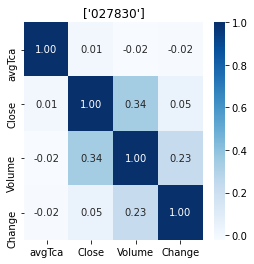

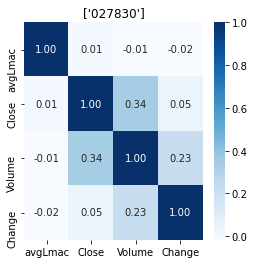

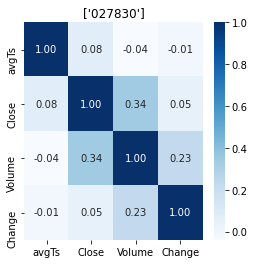

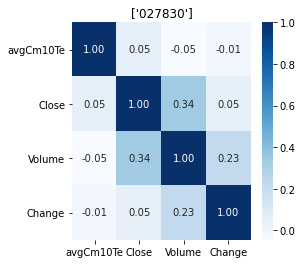

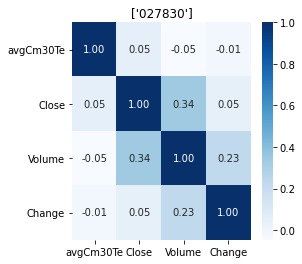

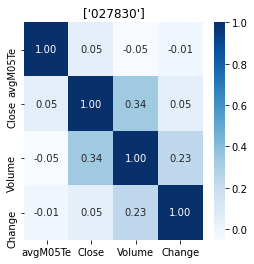

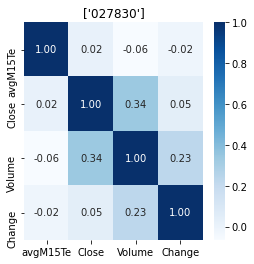

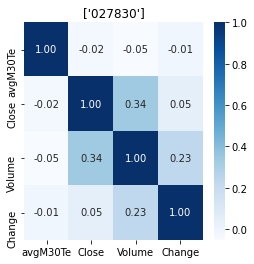

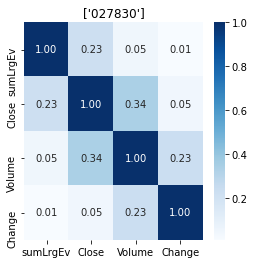

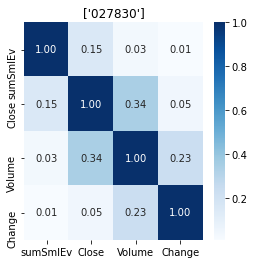

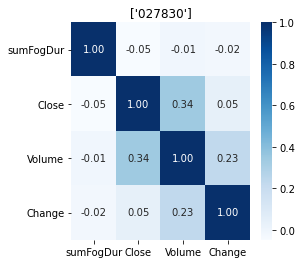

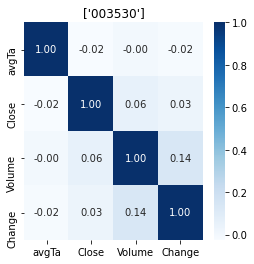

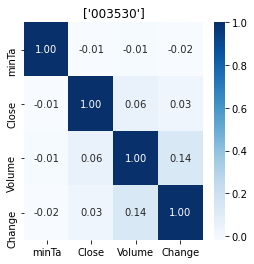

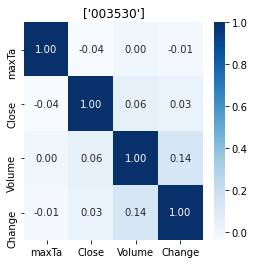

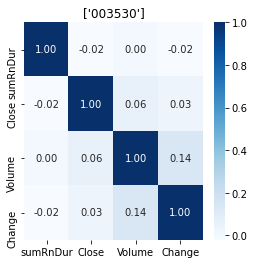

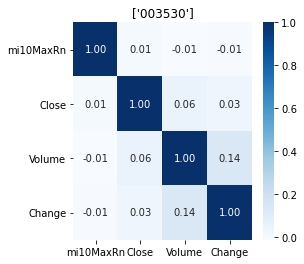

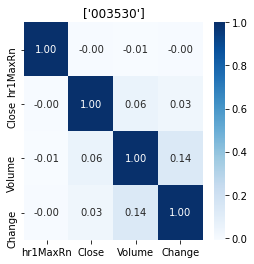

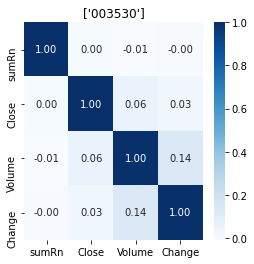

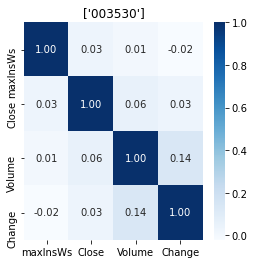

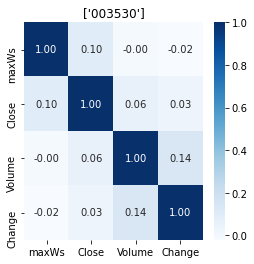

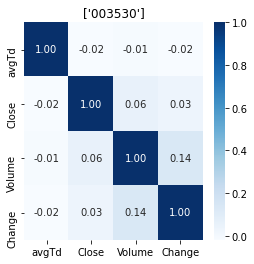

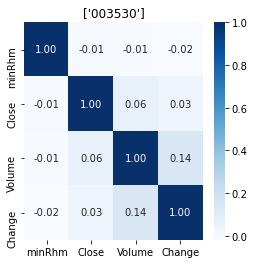

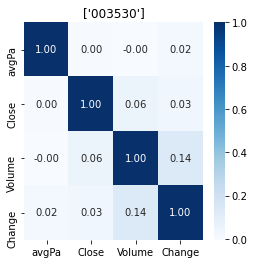

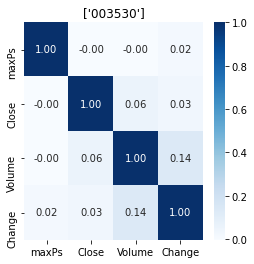

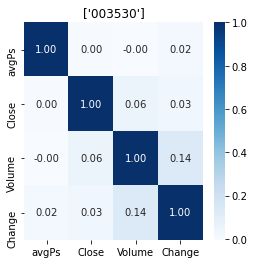

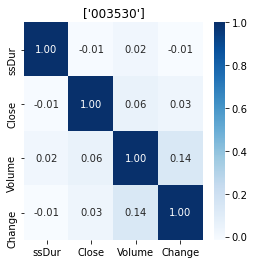

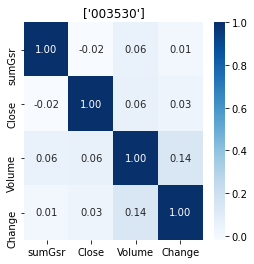

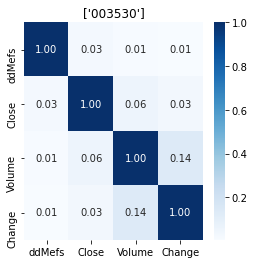

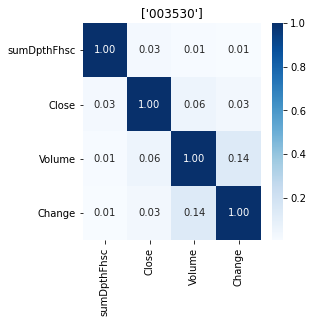

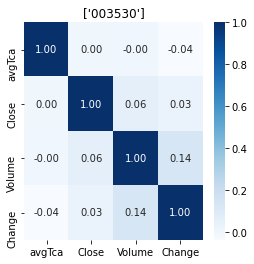

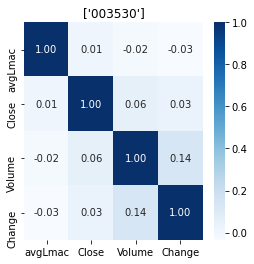

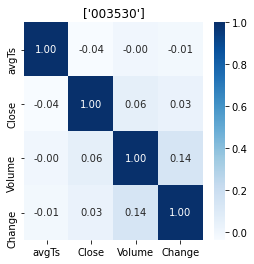

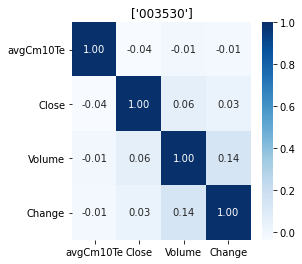

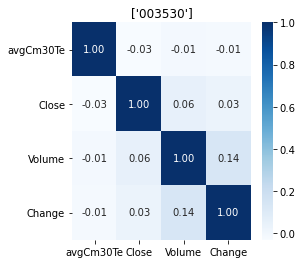

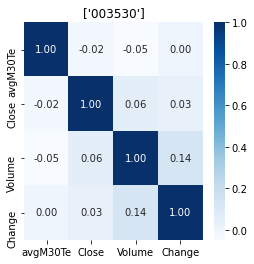

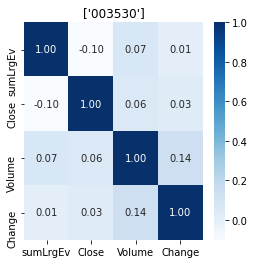

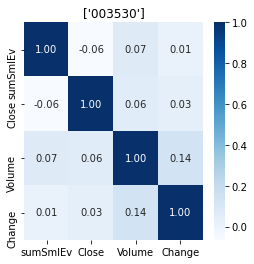

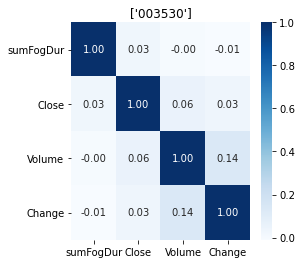

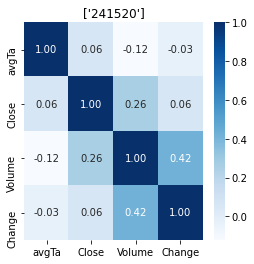

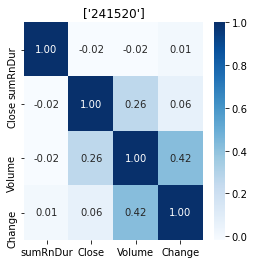

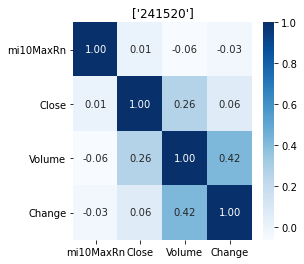

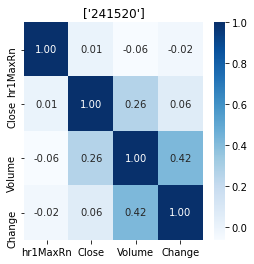

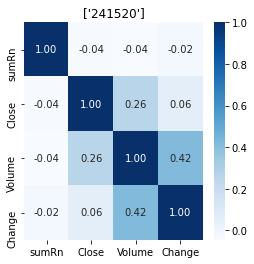

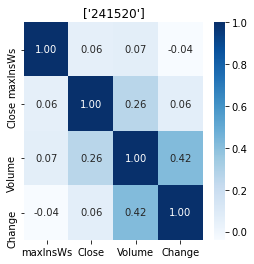

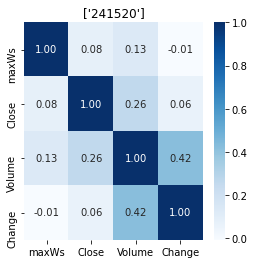

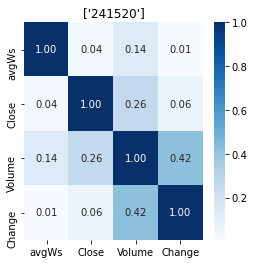

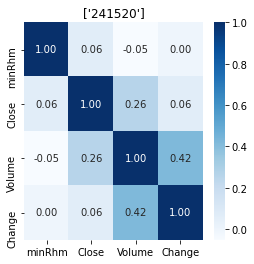

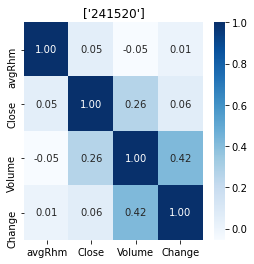

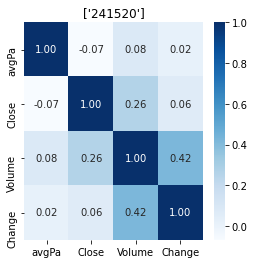

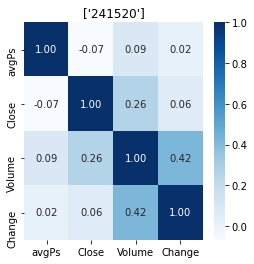

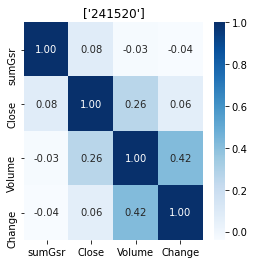

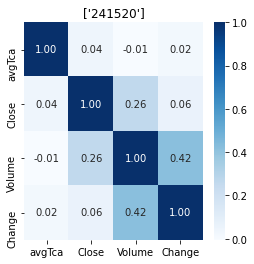

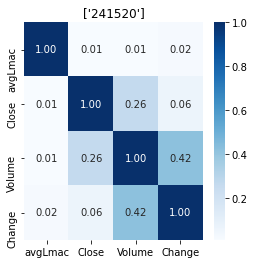

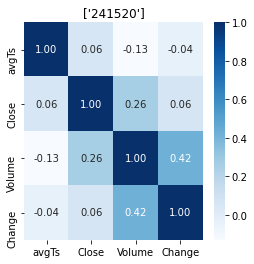

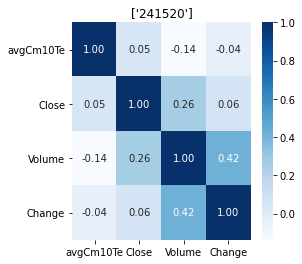

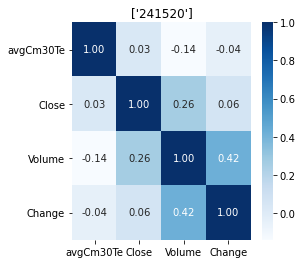

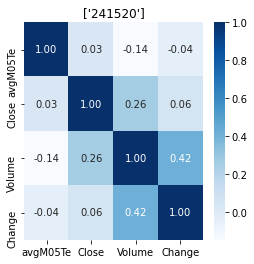

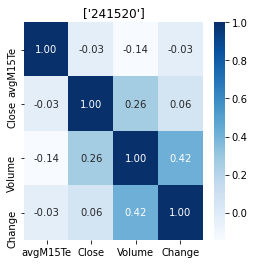

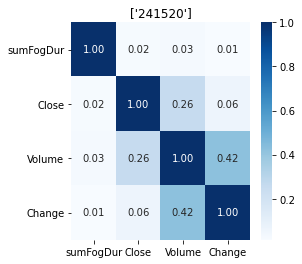

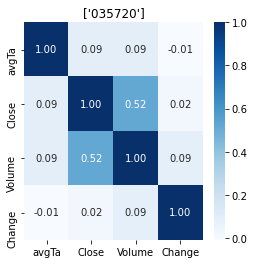

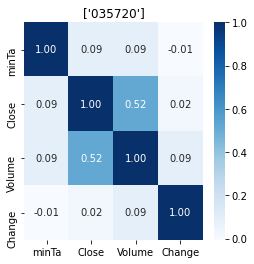

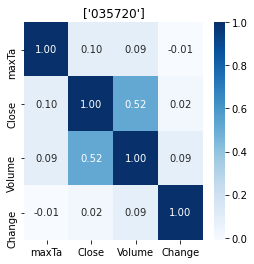

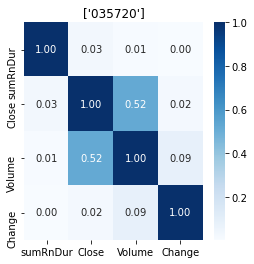

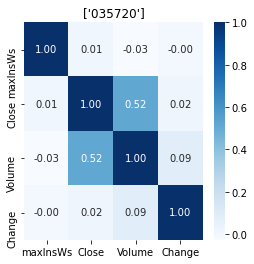

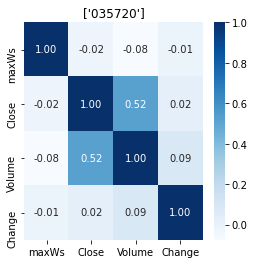

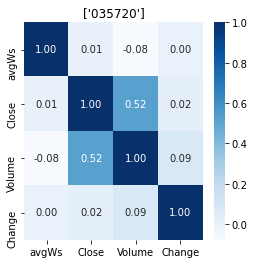

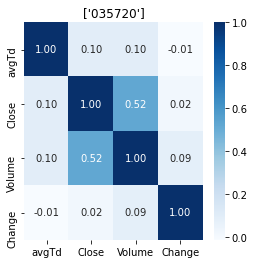

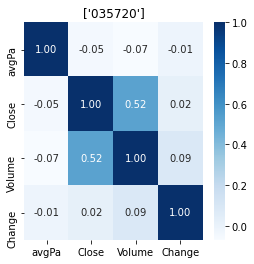

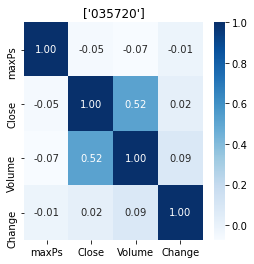

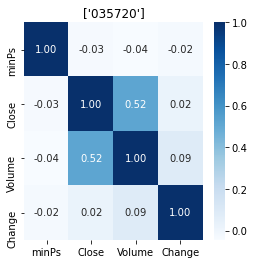

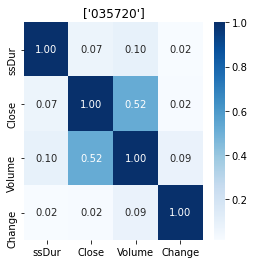

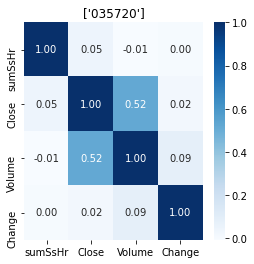

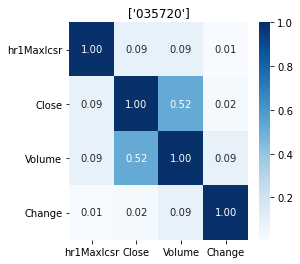

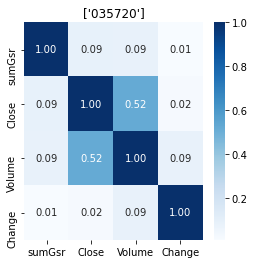

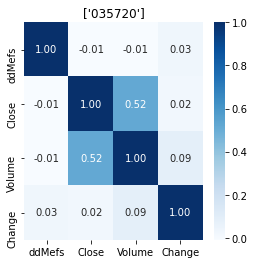

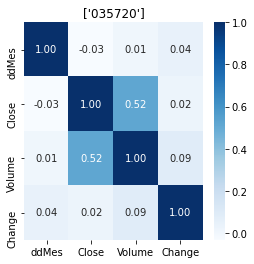

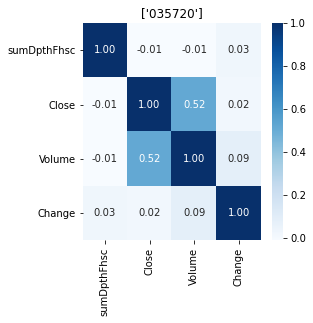

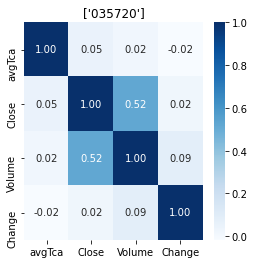

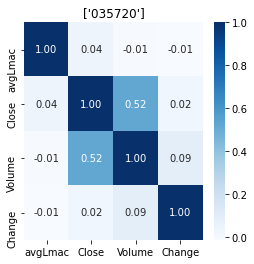

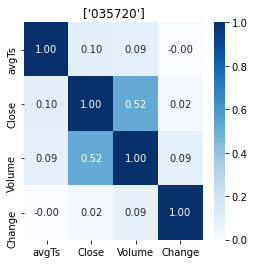

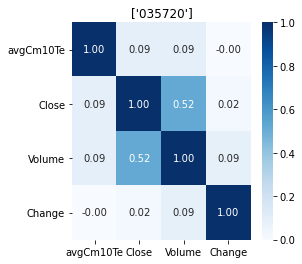

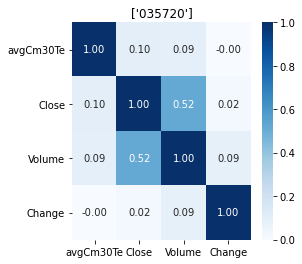

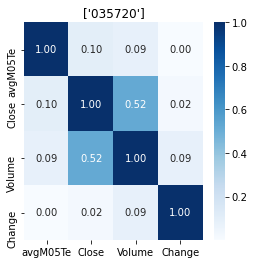

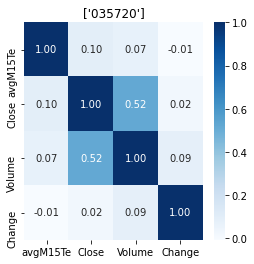

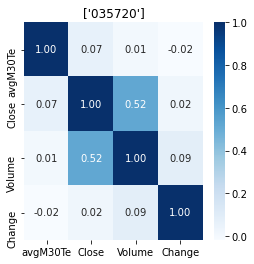

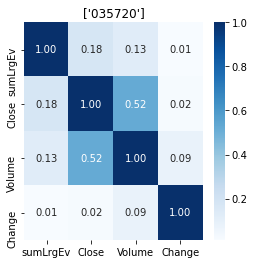

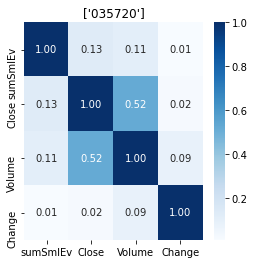

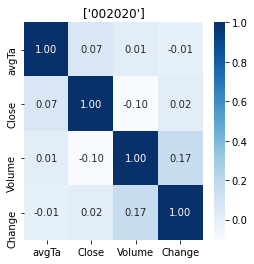

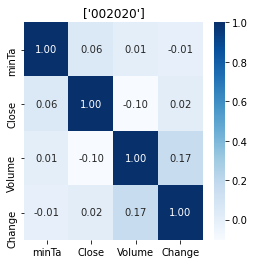

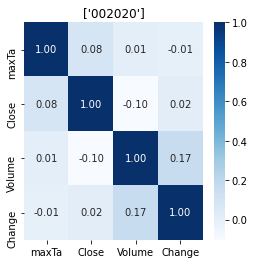

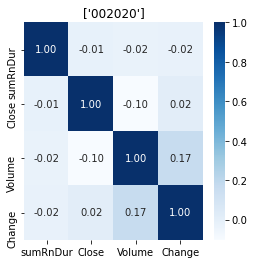

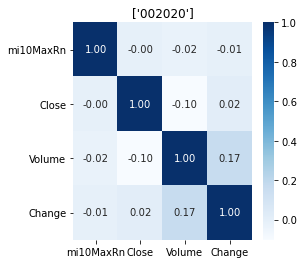

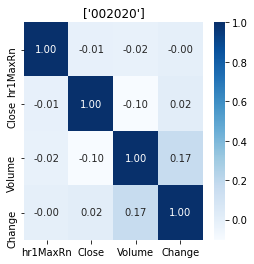

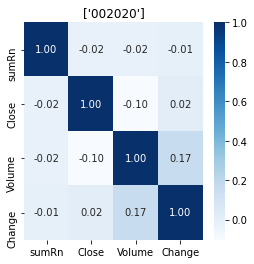

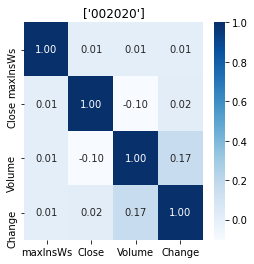

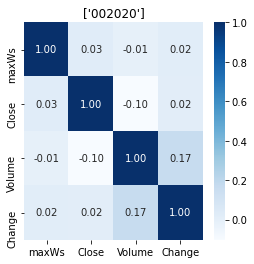

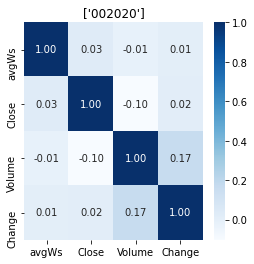

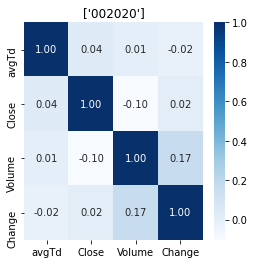

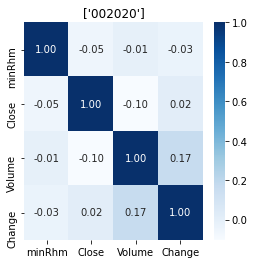

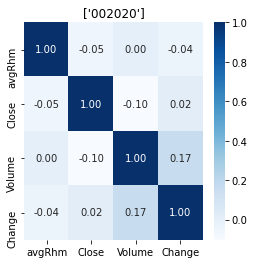

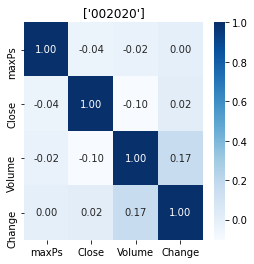

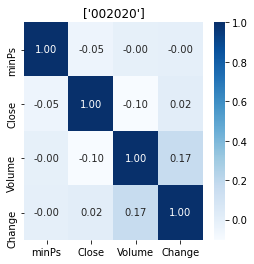

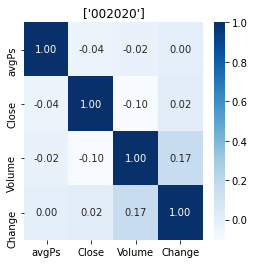

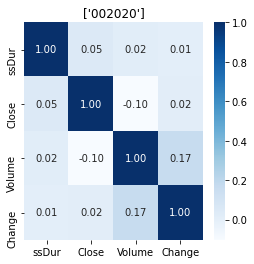

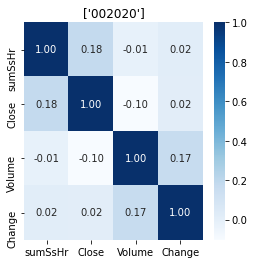

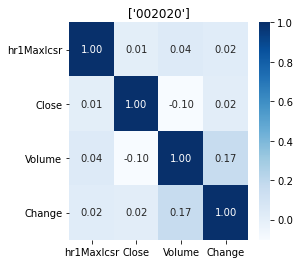

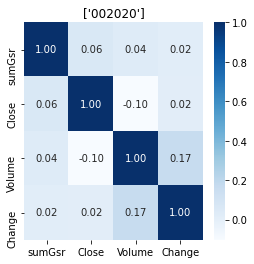

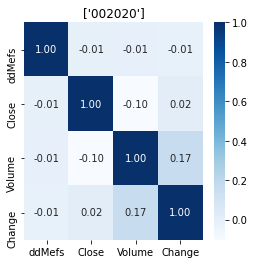

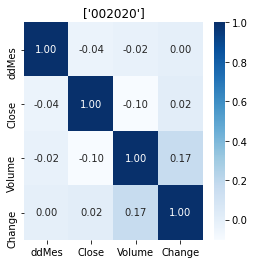

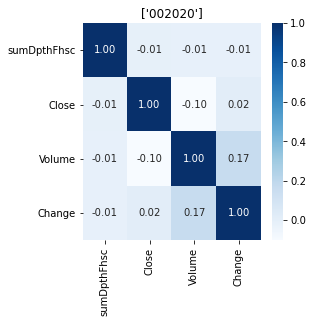

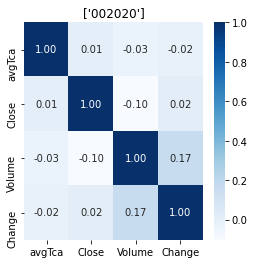

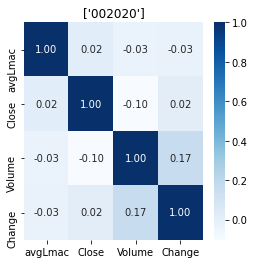

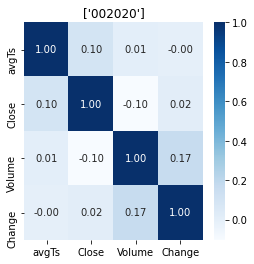

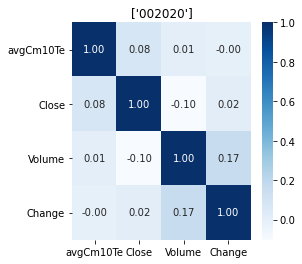

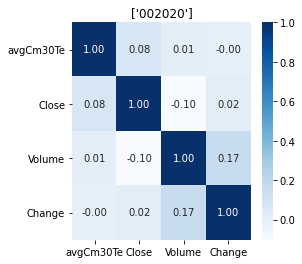

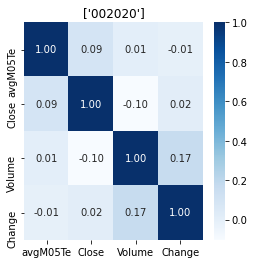

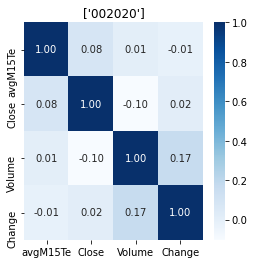

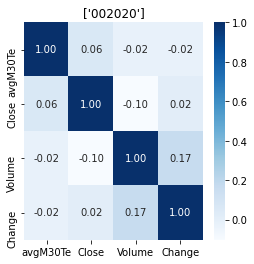

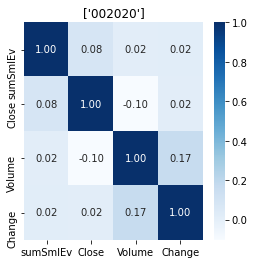

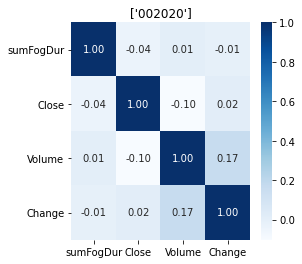

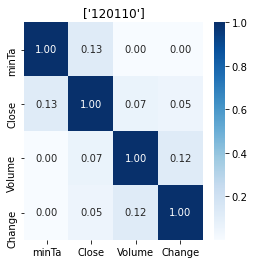

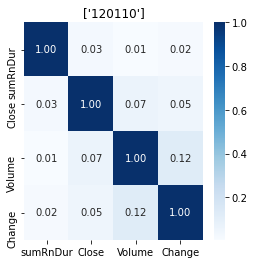

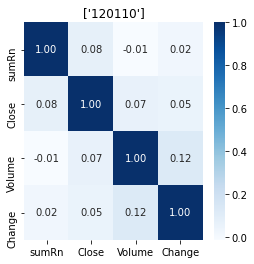

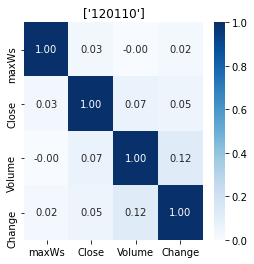

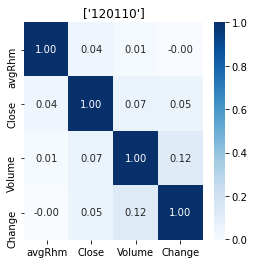

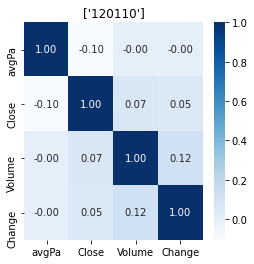

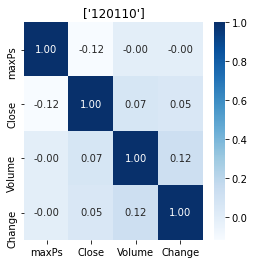

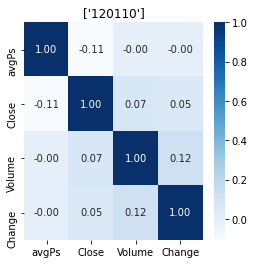

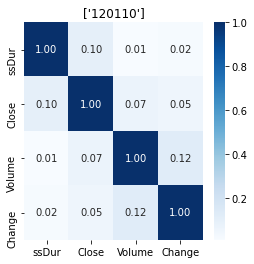

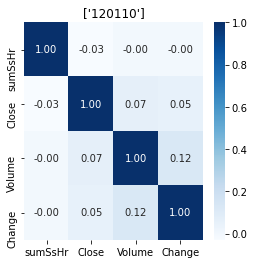

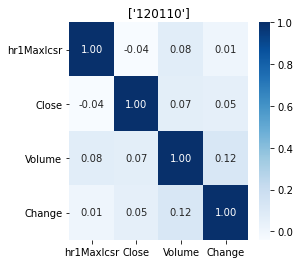

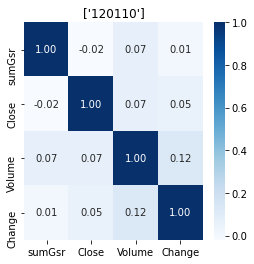

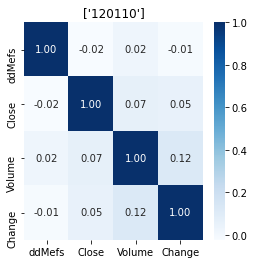

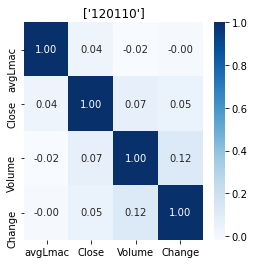

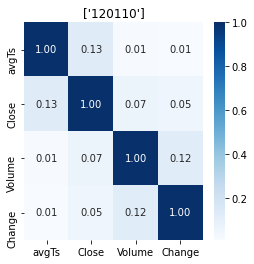

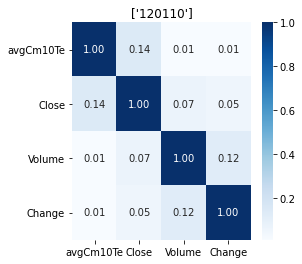

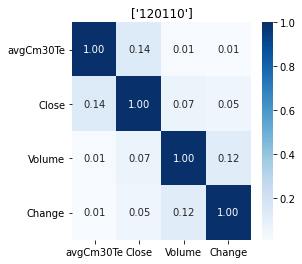

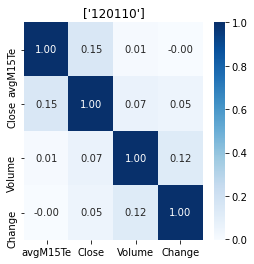

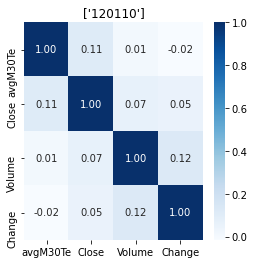

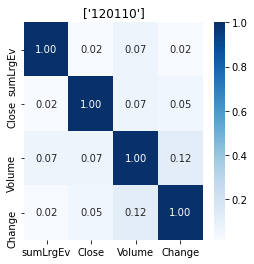

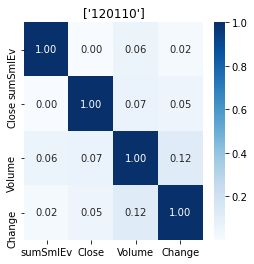

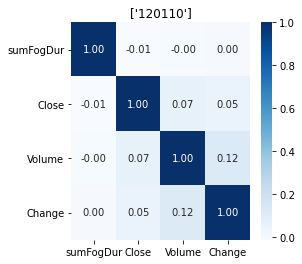

In [52]:
today = pd.datetime.now()
today_str = str(today)[:10].replace('-','')

theme_nm='두나무 관련주'
# path = '{}_list_{}.csv'.format(theme_nm, today_str)
path = '두나무 관련주_list_20211026.csv'

df_theme_code_result = pd.read_csv(path,index_col=0)
df_theme_code_result = df_theme_code_result.set_index(df_theme_code_result['Date'])
df_theme_code_result.drop('Date',axis=1,inplace=True)
df_theme_code_result.cd = df_theme_code_result.cd.apply(lambda x : str(x).zfill(6))



df_list=[]

for i in range(len(df_theme_code_result.cd.unique())) : 
    code = df_theme_code_result.cd.unique()[i]
    df = df_theme_code_result[df_theme_code_result['cd']==code]
    df_list.append(df)


for j in range(len(df_list)) : 
    df_list[j].index = df_list[j].index.astype('datetime64[ns]')
    for s in range(35):
        c=wth_df2.columns[s]
        d2= pd.DataFrame(wth_df2[c])
    #     print(c, d2)
        d2.index = d2.index.astype('datetime64[ns]')
    #     print(j)

        join_df = d2.join(df_list[j], how='inner')
    #     print(df_list[j].cd.unique())
        plt.figure(figsize =(4,4))
        plt.title(df_list[j].cd.unique())
        sns.heatmap(join_df.corr(method='pearson'),annot=True, cmap='Blues', fmt ='.2f')
    #     plt.savefig('img/{}_avgTa.png'.format(df_list[j].cd.unique()))